In [1]:
import cv2
import dlib
import imutils
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt

import face_recognition

In [2]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [3]:
def _trim_css_to_bounds(css, image_shape):
    return max(css[0], 0), min(css[1], image_shape[1]), min(css[2], image_shape[0]), max(css[3], 0)


def _rect_to_css(rect):
    return rect.top(), rect.right(), rect.bottom(), rect.left()


def _raw_face_locations(img, number_of_times_to_upsample=1):
    return detector(img, number_of_times_to_upsample)
    

def face_locations(img, number_of_times_to_upsample=1):
    return [_trim_css_to_bounds(_rect_to_css(face.rect), img.shape) for face in _raw_face_locations(img, number_of_times_to_upsample)]

In [4]:
def find_dog_face(input_image, size=None, debug=False):
    image = input_image.copy()
    
    if size:
        image = imutils.resize(image, width=size)
        
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dets = detector(gray_image, 1)
    
    print('Found {} faces.'.format(len(dets)))
    
    for (i, det) in enumerate(dets):
        # 얼굴 영역의 얼굴 랜드마크를 결정한 다음 
        # 얼굴 랜드마크(x, y) 좌표를 NumPy Array로 변환합니다.
        shape = predictor(image, det.rect)
        shape = face_utils.shape_to_np(shape)

        # dlib의 사각형을 OpenCV bounding box로 변환(x, y, w, h)
        (x, y, w, h) = face_utils.rect_to_bb(det.rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        if debug:
            # 얼굴 랜드마크에 포인트를 그립니다.
            for (i, (x, y)) in enumerate(shape):
                cv2.circle(image, (x, y), int(image.shape[1]/250), (0, 0, 255), -1)
                # cv2.putText(image, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255), 1)
        
    plt_imshow(["Original", "Find Faces"], [input_image, image], figsize=(16,10))

In [9]:
face_landmark_detector_path = 'lib/landmark/dogHeadDetector.dat'
face_landmark_predictor_path = 'lib/landmark/landmarkDetector.dat'

detector = dlib.cnn_face_detection_model_v1(face_landmark_detector_path)
predictor = dlib.shape_predictor(face_landmark_predictor_path)

In [12]:
image_path = 'asset/images/dog_test.jpg'
image = cv2.imread(image_path)

Found 4 faces.


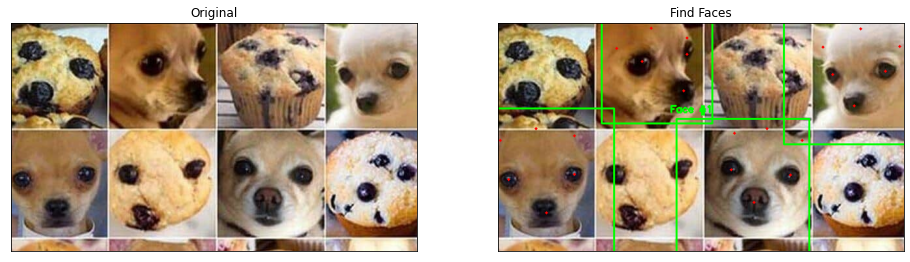

In [13]:
find_dog_face(image, debug=True)

In [14]:
def draw_label(input_image, coordinates, label):
    image = input_image.copy()
    (top, right, bottom, left) = coordinates
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 5)
    cv2.putText(image, label, (left - 10, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    
    return image

In [15]:
def add_known_face(face_image_path, name):
    face_image = cv2.imread(face_image_path)
    dets_locations = face_locations(face_image, 1)
    face_encoding = face_recognition.face_encodings(face_image, dets_locations)[0]
    
    detected_face_image = draw_label(face_image, dets_locations[0], name)
    
    known_face_encodings.append(face_encoding)
    known_face_names.append(name)
    
    plt_imshow(["Input Image", "Detected Face"], [face_image, detected_face_image])

In [16]:
def name_labeling(input_image, size=None):
    image = input_image.copy()
    
    if size:
        image = imutils.resize(image, width=size)
        
        
    dets_locations = face_locations(image)
    face_encodings = face_recognition.face_encodings(image, dets_locations)
    
    face_names = []

    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.4)
        name = "Unknown"

        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)

        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        face_names.append(name)
        
    for (top, right, bottom, left), name in zip(dets_locations, face_names):
        if name != "Unknown":
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)

        cv2.rectangle(image, (left, top), (right, bottom), color, 1)
        cv2.rectangle(image, (left, bottom - 10), (right, bottom), color, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(image, name, (left + 3, bottom - 3), font, 0.2, (0, 0, 0), 1)
        
    plt_imshow("Output", image, figsize=(24, 15))

In [22]:
known_face_encodings = []
known_face_names = []

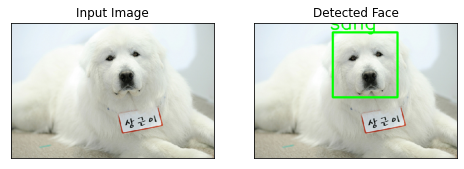

In [23]:
add_known_face("asset/images/dog1.jpg", "sang")

In [24]:
test_image_path = 'asset/images/dog3.jpg'
test_image = cv2.imread(test_image_path)

if test_image is None:
    print('The image does not exist in the path.')
else:
    print('image loading complete.')

image loading complete.


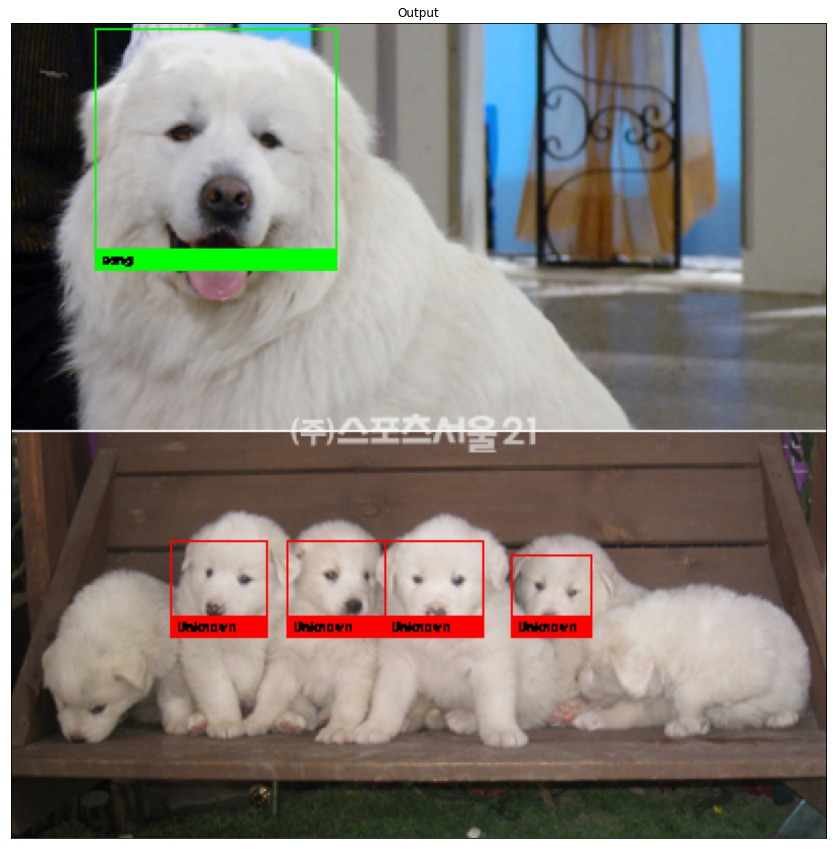

In [25]:
name_labeling(test_image)